In [7]:
import chex
import optax
import haiku as hk
import pandas as pd
import matplotlib.pylab as plt

from args import *
from model import *
from tqdm import tqdm
from scipy.stats import gaussian_kde


## Data Generation

In [8]:
from data_generation import *

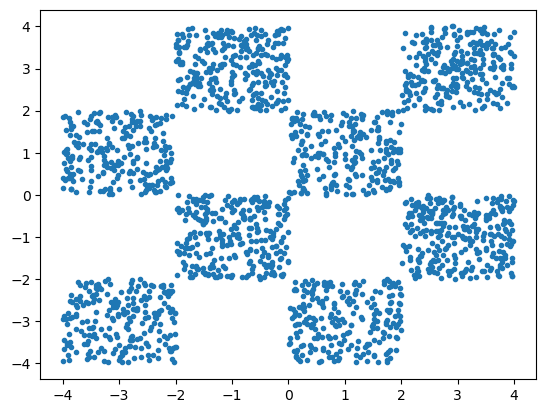

In [9]:
data_checkerboard = generate_checkerboard(num=2000, rng=np.random.default_rng())
data_checkerboard_holdout = generate_checkerboard(num=500, rng=np.random.default_rng())
plt.plot(data_checkerboard[:, 0], data_checkerboard[:, 1], '.')

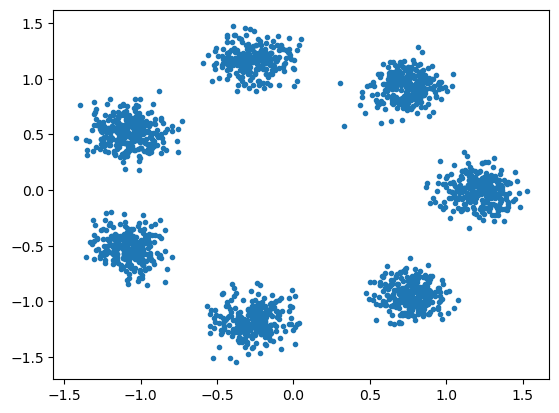

In [10]:
data_gaussian_mixtures = generate_gaussian_mixtures(num=2000, rng=np.random.default_rng())
data_gaussian_mixtures_holdout = generate_gaussian_mixtures(num=500, rng=np.random.default_rng())
plt.plot(data_gaussian_mixtures[:, 0], data_gaussian_mixtures[:, 1], '.')

## Model and Params Setup

In [11]:
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))

dataloader_checkerboard = JaxDataLoader(data_checkerboard, batch_size=128, shuffle=True)
dataloader_gaussian_mixtures = JaxDataLoader(data_gaussian_mixtures, batch_size=128, shuffle=True)

dataloader_checkerboard_holdout = JaxDataLoader(data_checkerboard_holdout, batch_size=128, shuffle=True)
dataloader_gaussian_mixtures_holdout = JaxDataLoader(data_gaussian_mixtures_holdout, batch_size=128, shuffle=True)

first_batch_checkerboard = next(iter(dataloader_checkerboard))

In [12]:
model_dsm = DSM(features=[256, 128, 64, 32, 2])
model_dsm_ = DSM(features=[256, 128, 64, 32, 2])
print(model_dsm.tabulate({'params': next(prng_seq)}, np.zeros((1, 2))))

params_dsm = model_dsm.init(next(prng_seq), first_batch_checkerboard[:1, ...])
optimizer_dsm = optax.adam(learning_rate=1e-3)
opt_state_dsm = optimizer_dsm.init(params_dsm)

params_dsm_ = model_dsm_.init(next(prng_seq), first_batch_checkerboard[:1, ...])
optimizer_dsm_ = optax.adam(learning_rate=1e-3)
opt_state_dsm_ = optimizer_dsm_.init(params_dsm_)

total_loss_dsm = []
total_loss_dsm_ = []

total_loss_dsm_holdout = []
total_loss_dsm_holdout_ = []


                                  DSM Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs         ┃ outputs        ┃ params                  ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DSM    │ float32[1,2]   │ float32[1,2]   │                         │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]   │ float32[1,256] │ bias: float32[256]      │
│         │        │                │                │ kernel: float32[2,256]  │
│         │        │                │                │                         │
│         │        │                │                │ 768 (3.1 KB)            │
├─────────┼────────┼────────────────┼────────────────┼─────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,256] │ float32[1,128] │ bias: float32[128]      │
│         │        │       

In [13]:
model_vae = VAE(hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, latent_dim, output_dim)
model_vae_ = VAE(hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, latent_dim, output_dim)
print(model_vae.tabulate({'params': next(prng_seq)}, np.zeros((1, 2)), next(prng_seq)))

params_vae = model_vae.init(next(prng_seq), first_batch_checkerboard[:1, ...], next(prng_seq))
optimizer_vae = optax.adam(learning_rate=1e-3)
opt_state_vae = optimizer_vae.init(params_vae)

params_vae_ = model_vae_.init(next(prng_seq), first_batch_checkerboard[:1, ...], next(prng_seq))
optimizer_vae_ = optax.adam(learning_rate=1e-3)
opt_state_vae_ = optimizer_vae_.init(params_vae_)

total_loss_vae = []
total_loss_vae_ = []

total_loss_vae_holdout = []
total_loss_vae_holdout_ = []


                                  VAE Summary                                   
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path           ┃ module     ┃ inputs        ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│                │ VAE        │ -             │ - float32[1,2] │               │
│                │            │ float32[1,2]  │ -              │               │
│                │            │ - uint32[2]   │ float32[1,16]  │               │
│                │            │               │ -              │               │
│                │            │               │ float32[1,16]  │               │
├────────────────┼────────────┼───────────────┼────────────────┼───────────────┤
│ VaeEncoder_0   │ VaeEncoder │ float32[1,2]  │ -              │               │
│                │            │               │ float32[1,16]  │               │
│                │         

## Loss Functions

In [14]:
def loss_function_dsm(params_: chex.ArrayTree, batch_: jax.Array, key) -> float:
    sig = 0.3
    noise = jax.random.normal(key, batch_.shape) * sig
    perturbed_x = batch_ + noise
    score_pred = model_dsm.apply(params_, perturbed_x)
    loss_ = jnp.mean(jnp.sum((perturbed_x + sig**2 * score_pred - batch_) ** 2, axis=1) / (sig**4))

    return loss_

def loss_function_dsm_(params_: chex.ArrayTree, batch_: jax.Array, key) -> float:
    sig = 0.3
    noise = jax.random.normal(key, batch_.shape) * sig
    perturbed_x = batch_ + noise
    score_pred = model_dsm_.apply(params_, perturbed_x)
    loss_ = jnp.mean(jnp.sum((perturbed_x + sig**2 * score_pred - batch_) ** 2, axis=1) / (sig**4))

    return loss_

def loss_function_vae(params, batch, key):
    beta = 0.03
    pred, mean, log_std = model_vae.apply(params, batch, key)
    mse_loss = jnp.mean(jnp.square(batch - pred))
    kl_loss = -0.5 * jnp.mean(jnp.sum(1 + log_std - jnp.square(mean) - jnp.exp(log_std), axis=-1))

    loss_ = mse_loss + beta * kl_loss

    return loss_

def loss_function_vae_(params, batch, key):
    beta = 0.03
    pred, mean, log_std = model_vae_.apply(params, batch, key)
    mse_loss = jnp.mean(jnp.square(batch - pred))
    kl_loss = -0.5 * jnp.mean(jnp.sum(1 + log_std - jnp.square(mean) - jnp.exp(log_std), axis=-1))

    loss_ = mse_loss + beta * kl_loss

    return loss_

## Training Functions

In [15]:
@jax.jit
def train_dsm(batch_, params_, opt_state_, key):
    loss_dsm, grads_ = jax.value_and_grad(loss_function_dsm)(params_, batch_, key)
    updates_, opt_state_ = optimizer_dsm.update(grads_, opt_state_)
    new_params_ = optax.apply_updates(params_, updates_)

    return loss_dsm, new_params_, opt_state_

@jax.jit
def train_dsm_(batch_, params_, opt_state_, key):
    loss_dsm_, grads_ = jax.value_and_grad(loss_function_dsm_)(params_, batch_, key)
    updates_, opt_state_ = optimizer_dsm_.update(grads_, opt_state_)
    new_params_ = optax.apply_updates(params_, updates_)

    return loss_dsm_, new_params_, opt_state_

@jax.jit
def train_vae(batch_, params_, opt_state_, key):
    loss_vae, grads_ = jax.value_and_grad(loss_function_vae)(params_, batch_, key)
    updates_, opt_state_ = optimizer_vae.update(grads_, opt_state_)
    new_params_ = optax.apply_updates(params_, updates_)

    return loss_vae, new_params_, opt_state_

@jax.jit
def train_vae_(batch_, params_, opt_state_, key):
    loss_vae_, grads_ = jax.value_and_grad(loss_function_vae_)(params_, batch_, key)
    updates_, opt_state_ = optimizer_vae_.update(grads_, opt_state_)
    new_params_ = optax.apply_updates(params_, updates_)

    return loss_vae_, new_params_, opt_state_

## Training Model DSM on Checkerboard Dataset


In [16]:
for i in tqdm(range(num_epoch)):
    loss_each_epoch = 0

    for batch in dataloader_checkerboard:
        loss_dsm, params_dsm, opt_state_dsm = train_dsm(batch, params_dsm, opt_state_dsm, next(prng_seq))
        loss_each_epoch += loss_dsm
    total_loss_dsm.append(loss_each_epoch/ len(dataloader_checkerboard))

    loss_holdout = 0
    for batch in dataloader_checkerboard_holdout:
        loss_holdout += loss_function_dsm(params_dsm, batch, next(prng_seq))
    total_loss_dsm_holdout.append(loss_holdout / len(dataloader_checkerboard_holdout))

total_loss_dsm = np.array(total_loss_dsm)
total_loss_dsm_holdout = np.array(total_loss_dsm_holdout)

100%|██████████| 5000/5000 [02:06<00:00, 39.42it/s]


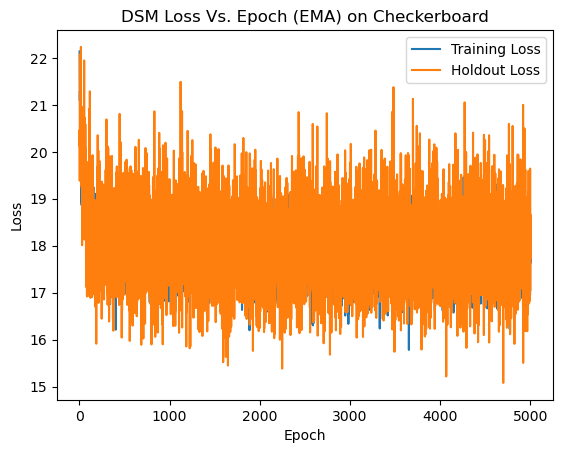

In [17]:
plt.plot(range(1, num_epoch + 1), total_loss_dsm, label="Training Loss")
plt.plot(range(1, num_epoch + 1), total_loss_dsm_holdout, label="Holdout Loss")
plt.title("DSM Loss Vs. Epoch (EMA) on Checkerboard")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

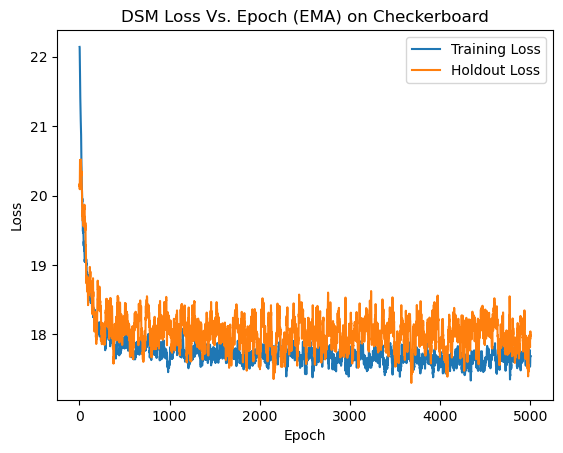

In [18]:
def compute_ema(loss_):
    ema = [loss_[0]]
    for t in range(1, len(loss_)):
        ema.append(0.1 * loss_[t] + (1 - 0.1) * ema[-1])
    return np.array(ema)

ema_loss = compute_ema(total_loss_dsm)
ema_loss_holdout = compute_ema(total_loss_dsm_holdout)

plt.plot(range(1, num_epoch + 1), ema_loss, label="Training Loss")
plt.plot(range(1, num_epoch + 1), ema_loss_holdout, label="Holdout Loss")
plt.title("DSM Loss Vs. Epoch (EMA) on Checkerboard")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Training Model DSM on Gaussian Mixtures Dataset

In [19]:
for i in tqdm(range(num_epoch)):
    loss_each_epoch = 0

    for batch in dataloader_gaussian_mixtures:
        loss_dsm_, params_dsm_, opt_state_dsm_ = train_dsm_(batch, params_dsm_, opt_state_dsm_, next(prng_seq))
        loss_each_epoch += loss_dsm_
    total_loss_dsm_.append(loss_each_epoch / len(dataloader_gaussian_mixtures))

    loss_holdout = 0
    for batch in dataloader_gaussian_mixtures_holdout:
        loss_holdout += loss_function_dsm_(params_dsm_, batch, next(prng_seq))
    total_loss_dsm_holdout_.append(loss_holdout / len(dataloader_gaussian_mixtures_holdout))

total_loss_dsm_ = np.array(total_loss_dsm_)
total_loss_dsm_holdout_ = np.array(total_loss_dsm_holdout_)

100%|██████████| 5000/5000 [02:00<00:00, 41.41it/s]


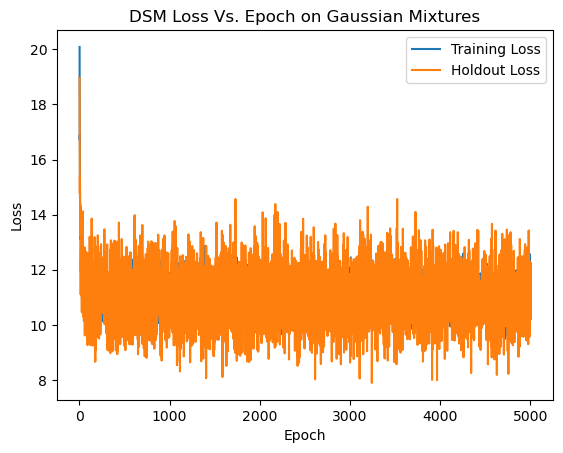

In [20]:
plt.plot(range(1, num_epoch + 1), total_loss_dsm_, label="Training Loss")
plt.plot(range(1, num_epoch + 1), total_loss_dsm_holdout_, label="Holdout Loss")
plt.title("DSM Loss Vs. Epoch on Gaussian Mixtures")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

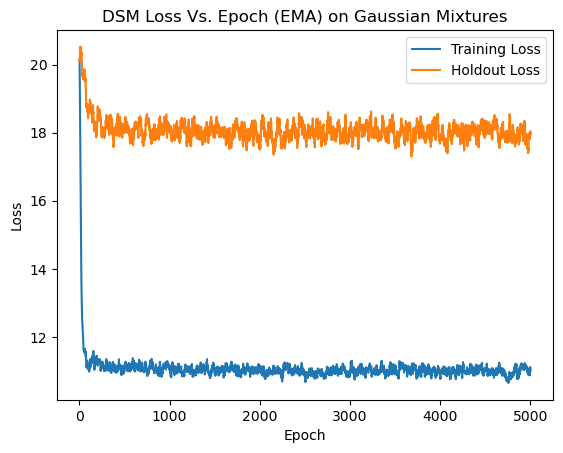

In [21]:
ema_loss_ = compute_ema(total_loss_dsm_)
ema_loss_holdout_ = compute_ema(total_loss_dsm_holdout)

plt.plot(range(1, num_epoch + 1), ema_loss_, label="Training Loss")
plt.plot(range(1, num_epoch + 1), ema_loss_holdout_, label="Holdout Loss")
plt.title("DSM Loss Vs. Epoch (EMA) on Gaussian Mixtures")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Training Model VAE on Checkerboard Dataset

In [22]:
for i in tqdm(range(num_epoch_vae)):
    loss_each_epoch = 0

    for batch in dataloader_checkerboard:
        loss_vae, params_vae, opt_state_vae = train_vae(batch, params_vae, opt_state_vae, next(prng_seq))
        loss_each_epoch += loss_vae
    total_loss_vae.append(loss_each_epoch / len(dataloader_checkerboard))
    
    loss_holdout = 0
    for batch in dataloader_checkerboard_holdout:
        loss_holdout += loss_function_vae(params_vae, batch, next(prng_seq))
    total_loss_vae_holdout.append(loss_holdout / len(dataloader_checkerboard_holdout))

total_loss_vae = np.array(total_loss_vae)
total_loss_vae_holdout = np.array(total_loss_vae_holdout)

100%|██████████| 5000/5000 [04:27<00:00, 18.71it/s]


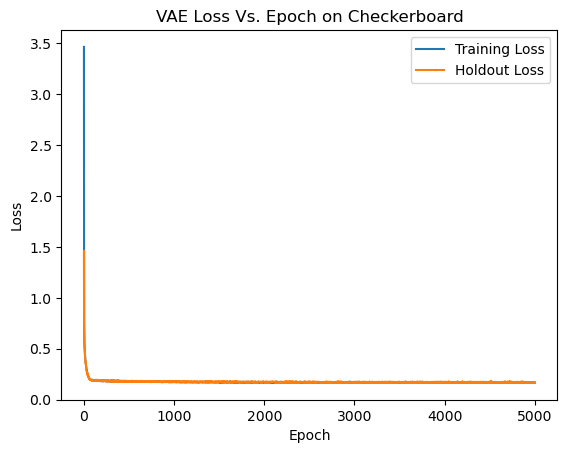

In [23]:
plt.plot(range(1, num_epoch + 1), total_loss_vae, label="Training Loss")
plt.plot(range(1, num_epoch + 1), total_loss_vae_holdout, label="Holdout Loss")
plt.title("VAE Loss Vs. Epoch on Checkerboard")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Training Model VAE on Gaussian Mixtures Dataset


In [24]:
for i in tqdm(range(num_epoch_vae)):
    loss_each_epoch = 0

    for batch in dataloader_gaussian_mixtures:
        loss_vae_, params_vae_, opt_state_vae_ = train_vae_(batch, params_vae_, opt_state_vae_, next(prng_seq))
        loss_each_epoch += loss_vae_
    total_loss_vae_.append(loss_each_epoch / len(dataloader_gaussian_mixtures))
    
    loss_holdout = 0
    for batch in dataloader_gaussian_mixtures_holdout:
        loss_holdout += loss_function_vae_(params_vae_, batch, next(prng_seq))
    total_loss_vae_holdout_.append(loss_holdout / len(dataloader_gaussian_mixtures_holdout))


total_loss_vae_ = np.array(total_loss_vae_)
total_loss_vae_holdout_ = np.array(total_loss_vae_holdout_)

100%|██████████| 5000/5000 [04:19<00:00, 19.24it/s]


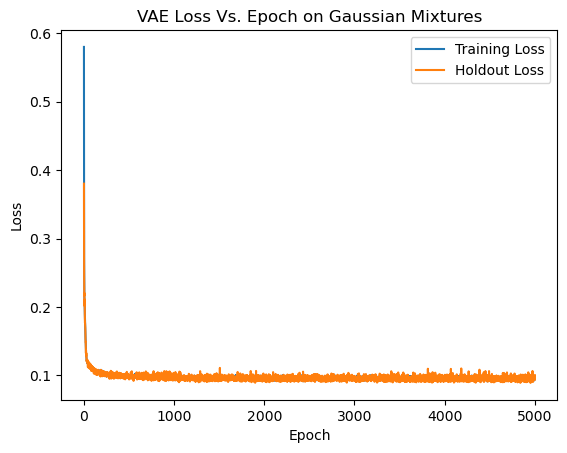

In [25]:
plt.plot(range(1, num_epoch + 1), total_loss_vae_, label="Training Loss")
plt.plot(range(1, num_epoch + 1), total_loss_vae_holdout_, label="Holdout Loss")
plt.title("VAE Loss Vs. Epoch on Gaussian Mixtures")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Qualitative comparison of model sample quality:


In [26]:
def langevin_sampling(model, params_, shape, num_steps=100, step_size=0.1, sig=0.1, key=None):
    if key is None:
        key = jax.random.PRNGKey(0)
    
    key, subkey = jax.random.split(key)
    samples = jax.random.normal(subkey, shape)
    
    for t in range(num_steps):
        key, subkey = jax.random.split(key)

        score = model.apply(params_, samples)
        
        noise = jax.random.normal(subkey, shape) 
        samples = samples + (step_size / (2 * sig**2)) * score + jnp.sqrt(step_size) * noise

    return samples

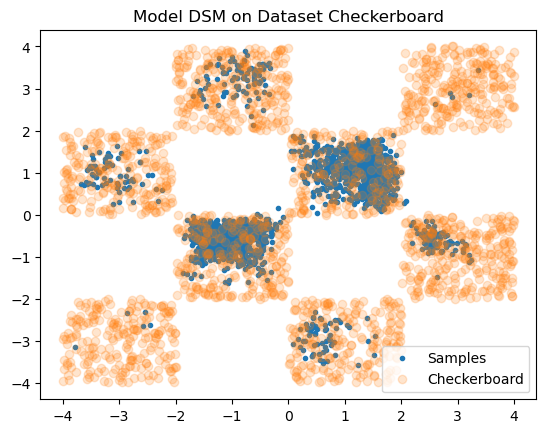

In [27]:
shape = (2000, 2)
num_steps = 2000
step_size = 0.001

key = jax.random.PRNGKey(42)
generated_samples_dsm = langevin_sampling(model_dsm, params_dsm, shape, num_steps, step_size, 0.3, key)

plt.plot(generated_samples_dsm[:, 0], generated_samples_dsm[:, 1], '.', label="Samples")
plt.plot(data_checkerboard[:, 0], data_checkerboard[:, 1], 'o', alpha=0.2, label="Checkerboard")
plt.title("Model DSM on Dataset Checkerboard")
plt.legend()
plt.show()

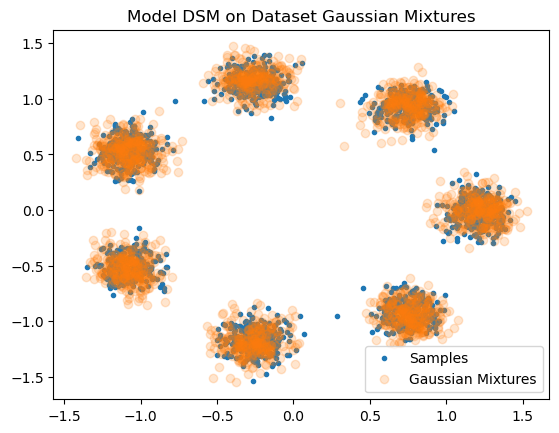

In [28]:
shape = (2000, 2)
num_steps = 1500
step_size = 0.001

key = jax.random.PRNGKey(42)
generated_samples_dsm_ = langevin_sampling(model_dsm_, params_dsm_, shape, num_steps, step_size, 0.3, key)

plt.plot(generated_samples_dsm_[:, 0], generated_samples_dsm_[:, 1], '.', label="Samples")
plt.plot(data_gaussian_mixtures[:, 0], data_gaussian_mixtures[:, 1], 'o', alpha=0.2, label="Gaussian Mixtures")
plt.title("Model DSM on Dataset Gaussian Mixtures")
plt.legend()
plt.show()

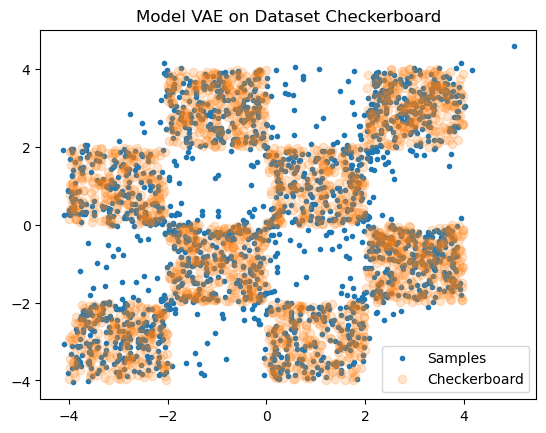

In [29]:
latent_samples = jax.random.normal(next(prng_seq), shape=(2000, 16))

generated_data_vae = model_vae.apply(params_vae, latent_samples, method=model_vae.decode)
generated_data_vae = np.array(generated_data_vae)

plt.plot(generated_data_vae[:, 0], generated_data_vae[:, 1], '.', label="Samples")
plt.plot(data_checkerboard[:, 0], data_checkerboard[:, 1], 'o', alpha=0.2, label="Checkerboard")
plt.title("Model VAE on Dataset Checkerboard")
plt.legend()
plt.show()
plt.show()

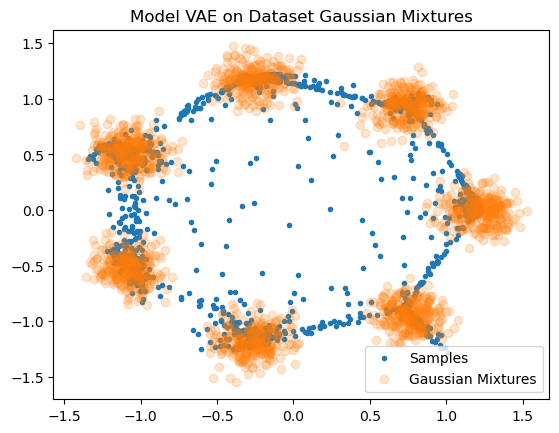

In [30]:
latent_samples = jax.random.normal(next(prng_seq), shape=(2000, 16))

generated_data_vae_ = model_vae_.apply(params_vae_, latent_samples, method=model_vae_.decode)
generated_data_vae_ = np.array(generated_data_vae_)

plt.plot(generated_data_vae_[:, 0], generated_data_vae_[:, 1], '.', label="Samples")
plt.plot(data_gaussian_mixtures[:, 0], data_gaussian_mixtures[:, 1], 'o', alpha=0.2, label="Gaussian Mixtures")
plt.title("Model VAE on Dataset Gaussian Mixtures")
plt.legend()
plt.show()
plt.show()

## Quantitative comparison of model sample quality


Checkerboard Dataset: log_likelihood: -5.2791, elbo: -4.6704
Gaussian Mixtures Dataset: log_likelihood: -1.2966, elbo: -2.5969


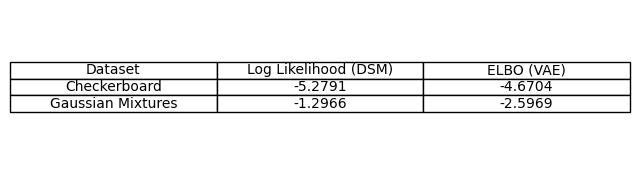

In [31]:
def dsm_kde(samples, holdout):
    kde = gaussian_kde(samples.T)
    log_likelihoods = kde.logpdf(holdout.T) 
    return log_likelihoods.mean()

def vae_elbo(data, model, params, key, num_samples=500):
    pred, mean, log_std = model.apply(params, data, key)

    total_mse = 0
    for _ in range(num_samples):
        sampled_z = mean + jnp.exp(0.5 * log_std) * jax.random.normal(key, shape=mean.shape)

        pred_decode = model.apply(params, sampled_z, method=model.decode)
        mse = -jnp.mean(jnp.square(data - pred_decode))
        total_mse += mse

    mean_mse = total_mse / num_samples

    kl_loss = -0.5 * jnp.mean(jnp.sum(1 + log_std - mean**2 - jnp.exp(log_std), axis=-1))

    elbo = mean_mse - kl_loss

    return elbo

log_likelihood = dsm_kde(generated_samples_dsm, holdout=data_checkerboard_holdout)
elbo = vae_elbo(data_checkerboard_holdout, model_vae, params_vae, next(prng_seq))
print(f'Checkerboard Dataset: log_likelihood: {log_likelihood:.4f}, elbo: {elbo:.4f}')

log_likelihood_ = dsm_kde(generated_samples_dsm_, holdout=data_gaussian_mixtures_holdout)
elbo_ = vae_elbo(data_gaussian_mixtures_holdout, model_vae_, params_vae_, next(prng_seq))
print(f'Gaussian Mixtures Dataset: log_likelihood: {log_likelihood_:.4f}, elbo: {elbo_:.4f}')

results = {
    "Dataset": ["Checkerboard", "Gaussian Mixtures"],
    "Log Likelihood (DSM)": [f'{log_likelihood:.4f}', f'{log_likelihood_:.4f}'],
    "ELBO (VAE)": [f'{elbo:.4f}', f'{elbo_:.4f}']
}

table_results = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(8, 2)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=table_results.values, colLabels=table_results.columns, cellLoc='center', loc='center')

plt.show()